# Test Vehicle Tracking


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
import pickle
from moviepy.editor import VideoFileClip
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sdc_functions import *
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from tqdm import tqdm

%matplotlib inline

vehicles_folder = '../vehicles'
non_vehicles_folder = '../non-vehicles'

vehicles = glob.glob(vehicles_folder + '/**/*.png', recursive=True)
print('vehicles = ', len(vehicles))
print('image0 = ', vehicles[0])

non_vehicles = glob.glob(non_vehicles_folder + '/**/*.png', recursive=True)
print('non_vehicles = ', len(non_vehicles))
print('image0 = ', non_vehicles[0])

### Subsample 
sample_size = 500
vehicles = np.random.choice(vehicles, sample_size)
non_vehicles = np.random.choice(non_vehicles, sample_size)
print('Sampled to %d images.' % sample_size)

### Parameters
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 18  # HOG orientations
pix_per_cell = 6 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (24, 24) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, 720] # Min and max in y to search in slide_window()


vehicles =  8792
image0 =  ../vehicles/GTI_Far/image0000.png
non_vehicles =  8968
image0 =  ../non-vehicles/Extras/extra1.png
Sampled to 500 images.


In [ ]:
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2
# import glob
# import time
# import os
# import pickle
# from sklearn.svm import LinearSVC
# from sklearn.preprocessing import StandardScaler
# from skimage.feature import hog
# from sdc_functions import *
# from scipy.ndimage.measurements import label
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm

# %matplotlib inline


# vehicles_folder = '../vehicles'
# non_vehicles_folder = '../non-vehicles'

# vehicles = glob.glob(vehicles_folder + '/**/*.png', recursive=True)
# print('vehicles = ', len(vehicles))
# print('image0 = ', vehicles[0])

# non_vehicles = glob.glob(non_vehicles_folder + '/**/*.png', recursive=True)
# print('non_vehicles = ', len(non_vehicles))
# print('image0 = ', non_vehicles[0])

# ### Subsample 
# sample_size = 500
# vehicles = np.random.choice(vehicles, sample_size)
# non_vehicles = np.random.choice(non_vehicles, sample_size)
# print('Sampled to %d images.' % sample_size)

# ### Parameters
# color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 18  # HOG orientations
# pix_per_cell = 6 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
# spatial_size = (24, 24) # Spatial binning dimensions
# hist_bins = 16    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off
# y_start_stop = [300, 720] # Min and max in y to search in slide_window()

t=time.time()
car_features = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
t2=time.time()

print('Feature extracted :')
print('scaled_X =', len(scaled_X))
print('y =', len(y))
print('feature length = ', len(scaled_X[0]))
print('Time %.2f s' % (t2-t))



### Train SVC

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.01, random_state=rand_state)

print('X_train =', len(X_train));
print('X_test =', len(X_test));
print('y_train =', len(y_train));
print('y_test =', len(y_test));

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test)*100, 4))

## Store to file
store_data = {"svc":svc, "scaler": X_scaler}
with open('pickle_svc_scaler.p', 'wb') as f:
    pickle.dump(store_data, f)

## Restore
restore_data = pickle.load(open('pickle_svc_scaler.p', "rb" ))
svc = restore_data["svc"]
X_scaler = restore_data["scaler"]

## Draw test prediction
# plt.figure(figsize=(20, 20))
f, axarr = plt.subplots(10, 10, figsize=(20, 20))
for r in range(len(axarr)):
    for c in range(len(axarr[0])):
        if np.random.uniform() < 0.5:
            im = imread(np.random.choice(vehicles))
        else:
            im = imread(np.random.choice(non_vehicles))
        im = cv2.resize(im, (64, 64))
        features = extract_features_img(im, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        decision = svc.decision_function(test_features)
        axarr[r, c].axes.get_xaxis().set_ticks([])
        axarr[r, c].axes.get_yaxis().set_ticks([])
        axarr[r, c].set_title("%.2f" % decision[0], fontsize=12)
        axarr[r, c].imshow(im)



'''
# Show Sample Images
plt.subplot(1, 2, 1)
vehicle_img = imread(vehicles[np.random.randint(0, len(vehicles))])
plt.imshow(vehicle_img)
plt.subplot(1, 2, 2)
non_vehicle_img = imread(non_vehicles[np.random.randint(0, len(non_vehicles))])
plt.imshow(non_vehicle_img)
'''


In [ ]:
# ### Train SVC

# # Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     scaled_X, y, test_size=0.2, random_state=rand_state)

# print('X_train =', len(X_train));
# print('X_test =', len(X_test));
# print('y_train =', len(y_train));
# print('y_test =', len(y_test));

# # Use a linear SVC 
# svc = LinearSVC()
# # Check the training time for the SVC
# t=time.time()
# svc.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test)*100, 4))



100%|██████████| 6/6 [00:36<00:00,  6.14s/it]


'\n## Draw samples from all_hot_windows\n# plt.figure(figsize=(20, 20))\nf, axarr = plt.subplots(10, 10, figsize=(20, 20))\nfor r in range(len(axarr)):\n    for c in range(len(axarr[0])):\n        window = all_hot_windows[np.random.randint(0, len(all_hot_windows))]\n        im = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))\n        features = extract_features_img(im, color_space=color_space, \n                            spatial_size=spatial_size, hist_bins=hist_bins, \n                            orient=orient, pix_per_cell=pix_per_cell, \n                            cell_per_block=cell_per_block, \n                            hog_channel=hog_channel, spatial_feat=spatial_feat, \n                            hist_feat=hist_feat, hog_feat=hog_feat)\n        test_features = X_scaler.transform(np.array(features).reshape(1, -1))\n        decision = svc.decision_function(test_features)\n        axarr[r, c].axes.get_xaxis().set_ticks([])\n        axarr[r,

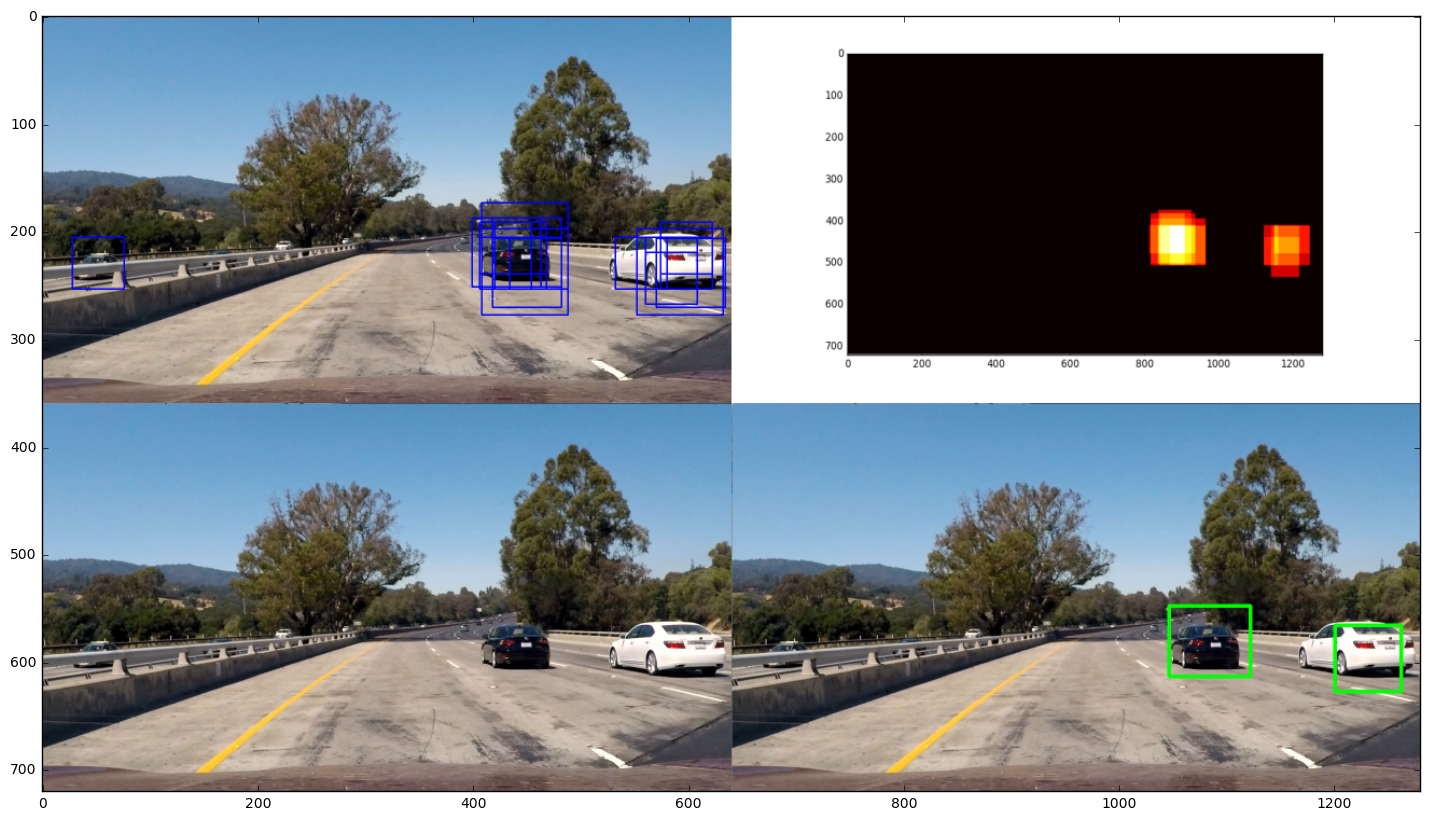

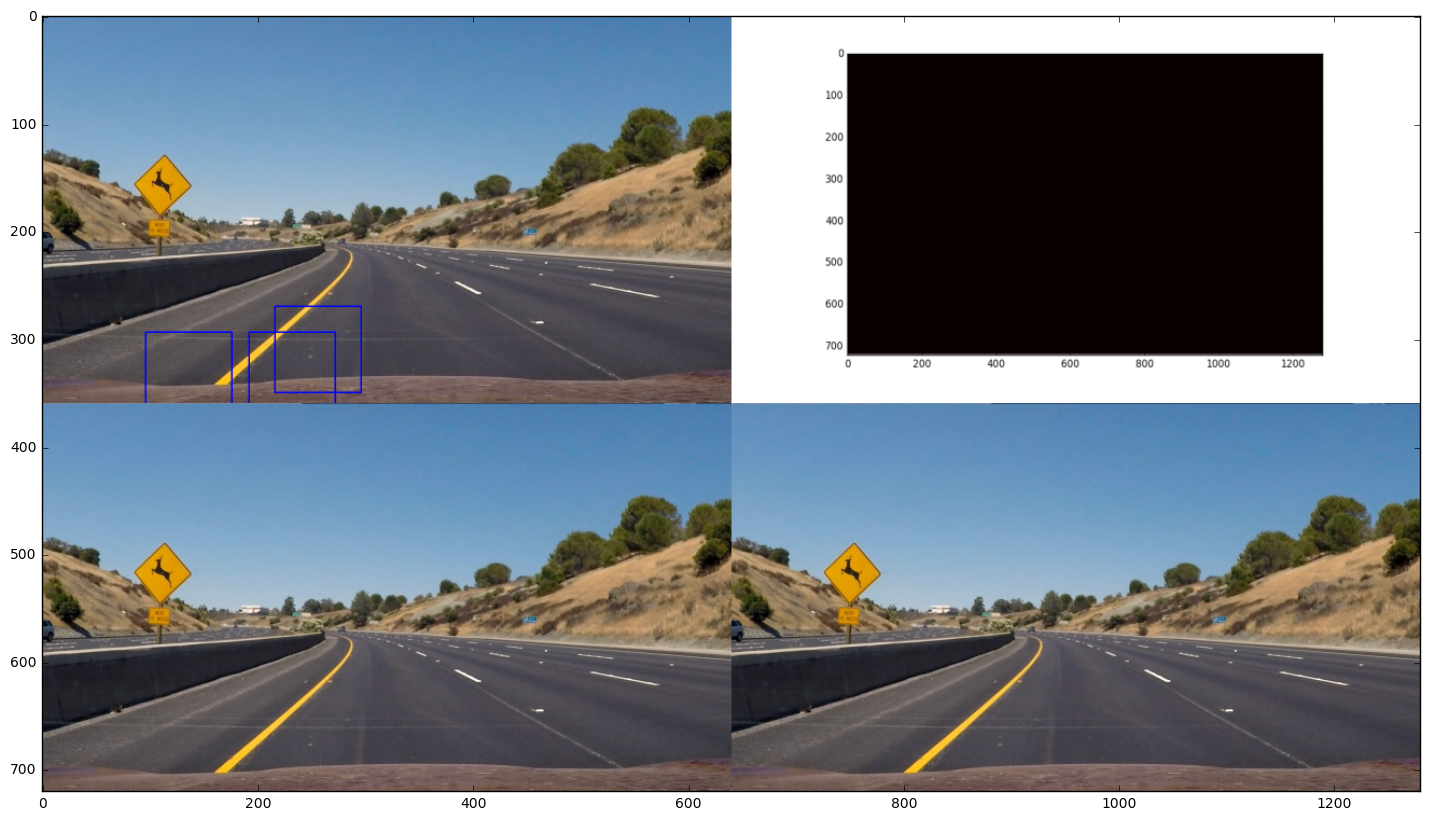

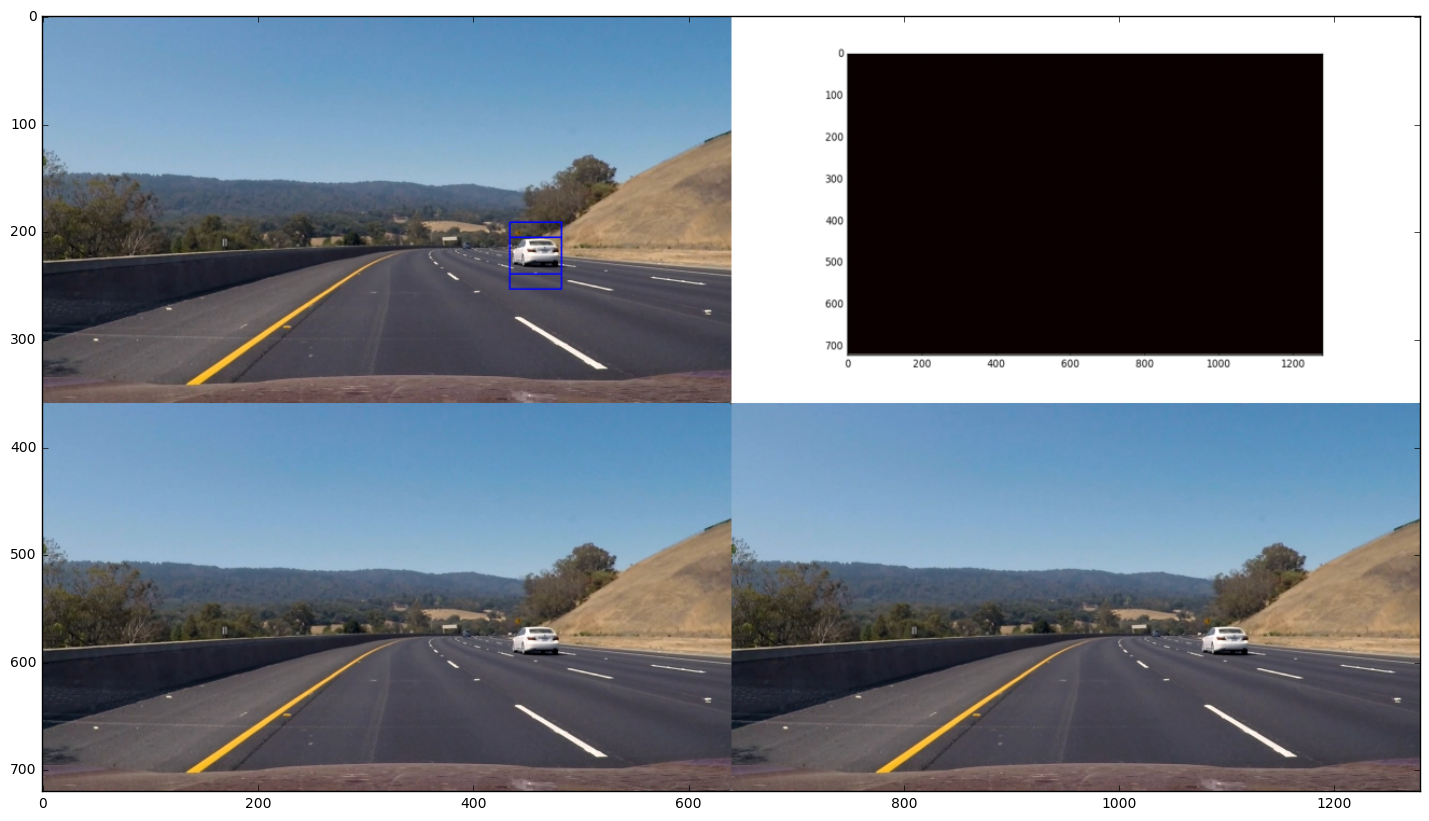

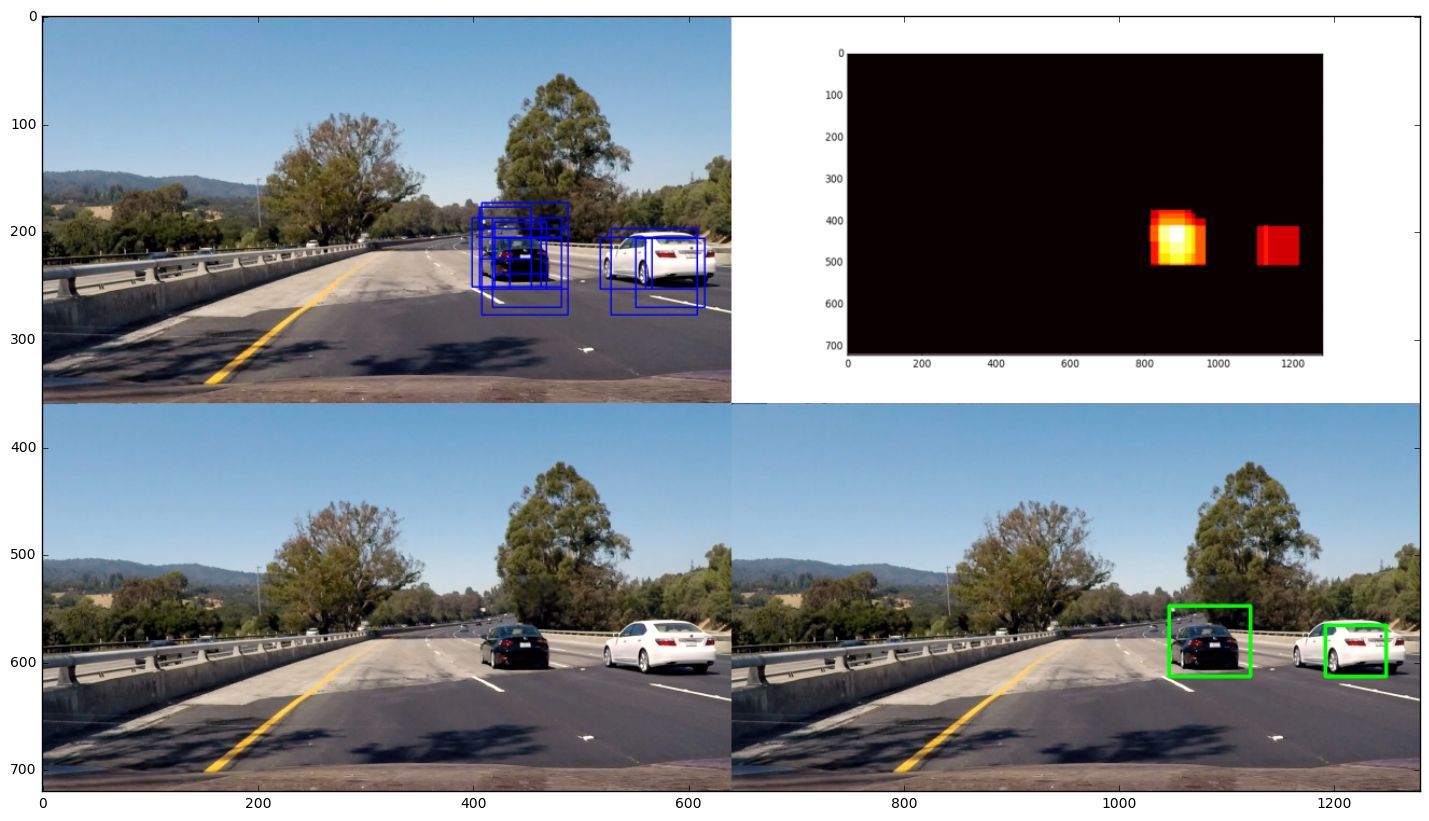

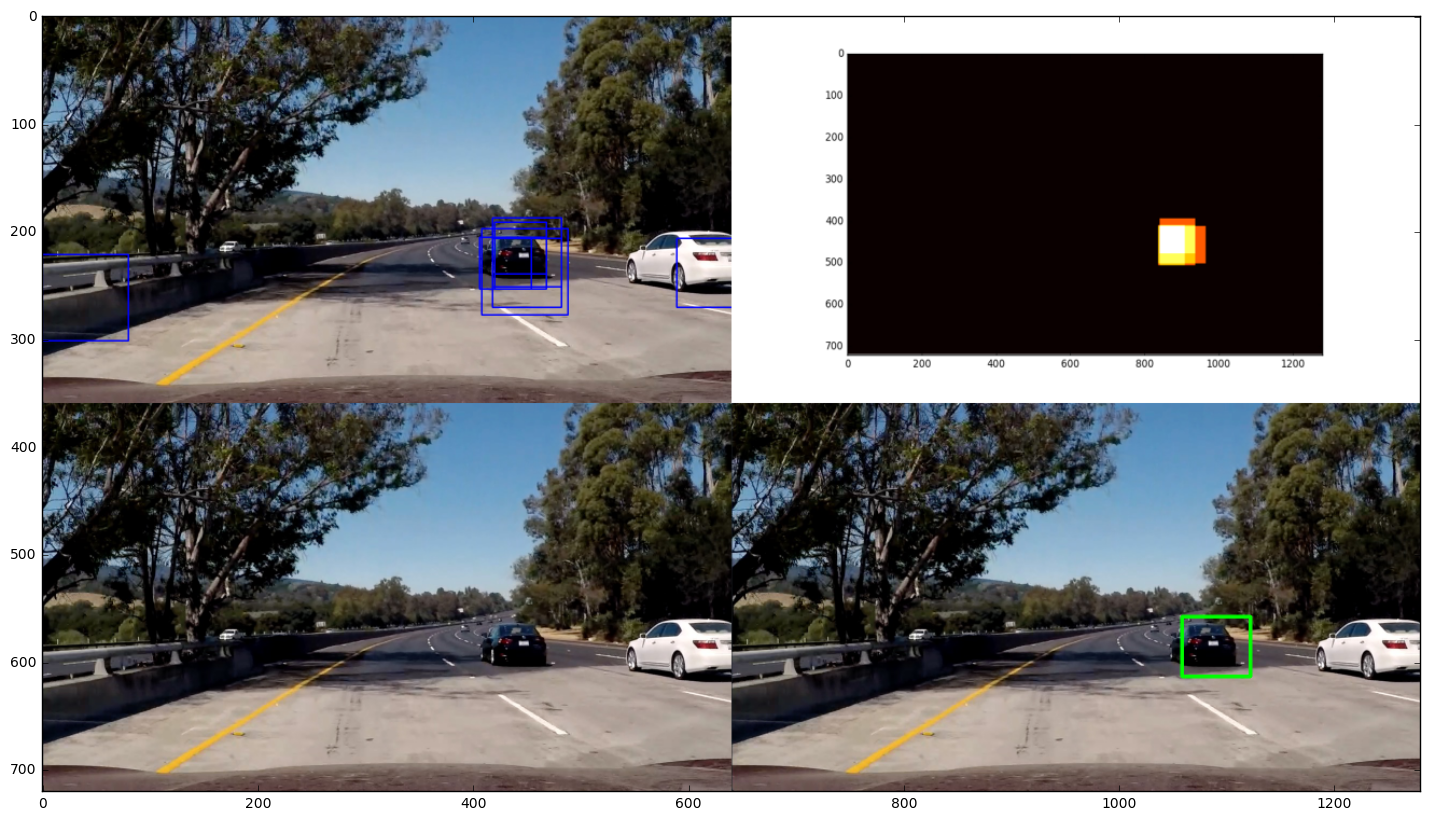

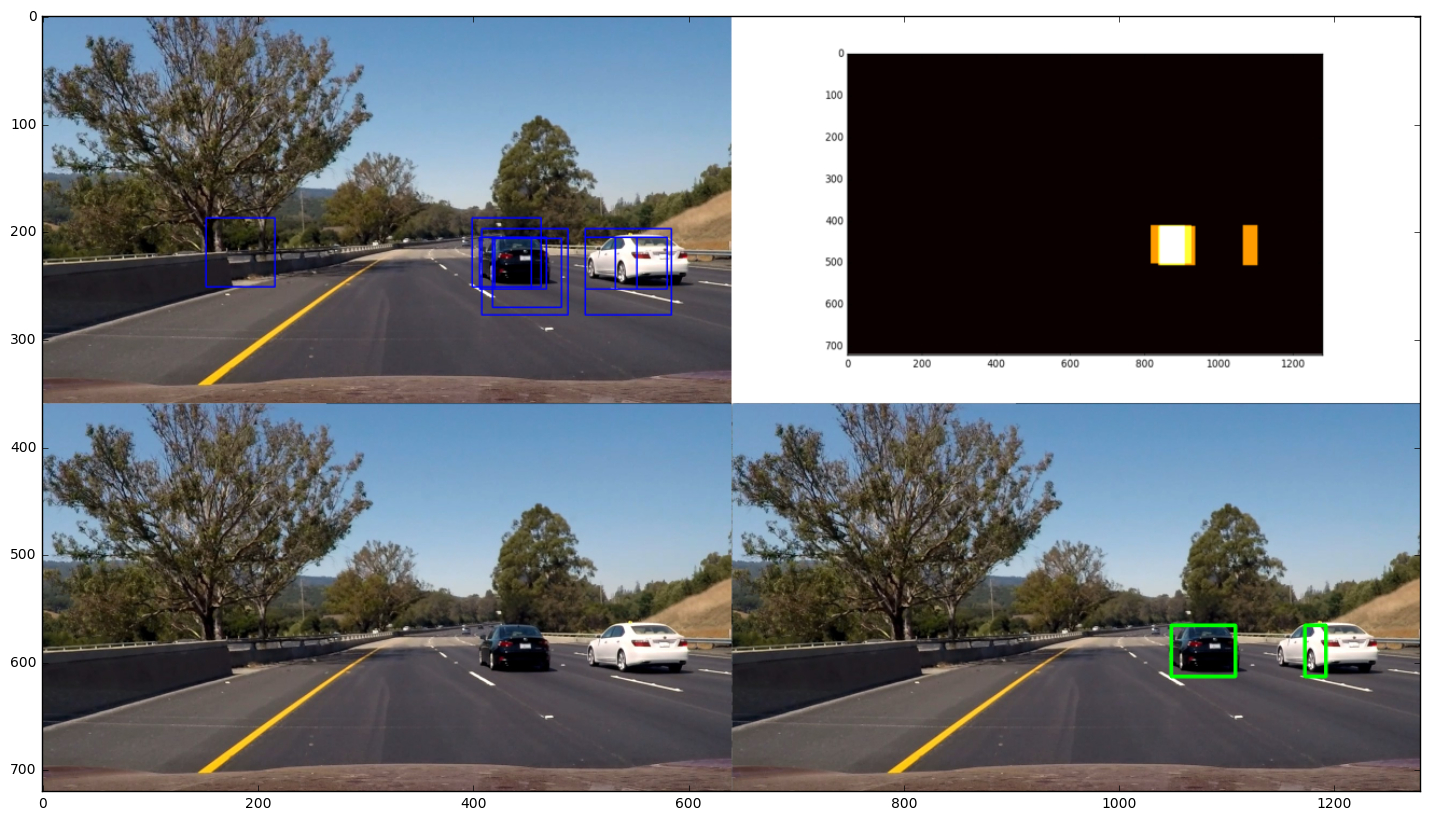

In [2]:
## Search in windows

# from sdc_functions import *

## Restore
restore_data = pickle.load(open('pickle_svc_scaler.p', "rb" ))
svc = restore_data["svc"]
X_scaler = restore_data["scaler"]


test_images = ['test_images/test1.jpg',
              'test_images/test2.jpg',
              'test_images/test3.jpg',
              'test_images/test4.jpg',
              'test_images/test5.jpg',
              'test_images/test6.jpg']

# images = [imread(img) for img in test_images]

window_sizes = [160, 128, 96] # [256, 224, 192, 160, 128, 96, 64]
window_sizes_box = [(b, b) for b in window_sizes]
# print('window_sizes_box =', window_sizes_box)

def process_func(image):
    
    resImg = np.zeros_like(image)
    
    # Show: Original Image
    compose_images(resImg, image, 2, 2, 3)

    all_hot_windows = []
    
    for widx, window_size in enumerate(window_sizes_box):
        t = time.time()
        overlap_factor = 1. - max(0.3, 20.0/window_size[0])
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=window_size, xy_overlap=(overlap_factor, overlap_factor))
#         all_windows.append(windows)
        t2 = time.time()
        
#         print('window_size=',window_size,'overlap=',overlap_factor,' num=', len(windows), ', %.2f seconds' % (t2-t) )

#     print('windows len =', len(windows))
#     print('windows[0] =', windows[0])

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        t3 = time.time()
#         print('hog time %.2f seconds' % (t3-t2) )
    
#         windows_counts[widx] += len(hot_windows)
        
    
        all_hot_windows.extend(hot_windows)
        
#     print('windows_counts =', windows_counts)
    
    ## Draw All Boxes
    draw_image = np.copy(image)
    windows_img = draw_boxes(draw_image, all_hot_windows, color=(0, 0, 255), thick=2)
    compose_images(resImg, windows_img, 2, 2, 1)
    
    ## Draw ALL ALL Boxes
#     draw_image = np.copy(image)
#     window_img = draw_boxes(draw_image, all_windows[0], color=(255, 0, 0), thick=2)                    
#     axs[idx, 1].imshow(window_img)

    
    ## Heat Map
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, all_hot_windows)

    heat = apply_threshold(heat, 2)
    labels = label(heat)
    
    ## Draw Heat Map
    final_map = np.clip(heat, 0, 255)
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(final_map, cmap='hot')
    data = get_fig_image(fig)
    compose_images(resImg, data, 2, 2, 2)
    
    


#     print(labels[1], 'cars found')
#     plt.subplot(1, 2, 2)

    ## Dtaw Labels Map
#     axs[idx, 2].set_title('%d cars found' % labels[1])
#     axs[idx, 2].imshow(labels[0], cmap='gray')
    
    ## Draw Outer Box
    bbox_image = draw_labeled_bboxes(image, labels)
    compose_images(resImg, bbox_image, 2, 2, 4)
    
    
    return resImg





# f, axs = plt.subplots(6, 1, figsize=(20, 20))
windows_counts = np.zeros(len(window_sizes_box))
for idx, timg in enumerate(tqdm(test_images)):
    image = imread(timg)
# image = imread('test_images/test5.jpg')
# image = imread('test_images/test2.jpg')
# image = imread('test_images/test3.jpg')
# image = imread('test_images/test4.jpg')
# image = imread('test_images/test5.jpg')
# image = imread('test_images/test6.jpg')
# print('image =', image)
# print('image2 =', imread(vehicles[0]))
# Normalize jpg to 0, 1
# image = image / 255

    draw_image = process_func(image)
    plt.figure(figsize=(20, 10))
    plt.imshow(draw_image)
#     axs[idx].imshow(draw_image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

'''
    all_hot_windows = []
    all_windows = []
    
    for widx, window_size in enumerate(window_sizes_box):
        t = time.time()
        overlap_factor = 1. - max(0.2, 20.0/window_size[0])
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=window_size, xy_overlap=(overlap_factor, overlap_factor))
        all_windows.append(windows)
        t2 = time.time()
        
        print('window_size=',window_size,'overlap=',overlap_factor,' num=', len(windows), ', %.2f seconds' % (t2-t) )

#     print('windows len =', len(windows))
#     print('windows[0] =', windows[0])

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        t3 = time.time()
        print('hog time %.2f seconds' % (t3-t2) )
    
        windows_counts[widx] += len(hot_windows)
        
    
        all_hot_windows.extend(hot_windows)
        
    print('windows_counts =', windows_counts)
    
    ## Draw All Boxes
    window_img = draw_boxes(draw_image, all_hot_windows, color=(0, 0, 255), thick=2)                    
    axs[idx, 0].imshow(window_img)
    
    ## Draw ALL ALL Boxes
    draw_image = np.copy(image)
    window_img = draw_boxes(draw_image, all_windows[0], color=(255, 0, 0), thick=2)                    
    axs[idx, 1].imshow(window_img)

    
    ## Heat Map
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, all_hot_windows)

    heat = apply_threshold(heat, 2)
    labels = label(heat)
    
    ## Draw Heat Map
#     final_map = np.clip(heat, 0, 255)
#     axs[idx, 1].imshow(final_map, cmap='hot')
    
    


#     print(labels[1], 'cars found')
#     plt.subplot(1, 2, 2)

    ## Dtaw Labels Map
#     axs[idx, 2].set_title('%d cars found' % labels[1])
#     axs[idx, 2].imshow(labels[0], cmap='gray')
    
    ## Draw Outer Box
#     draw_image = draw_labeled_bboxes(draw_image, labels)
#     axs[idx, 3].imshow(draw_image)


'''

'''
## Draw samples from all_hot_windows
# plt.figure(figsize=(20, 20))
f, axarr = plt.subplots(10, 10, figsize=(20, 20))
for r in range(len(axarr)):
    for c in range(len(axarr[0])):
        window = all_hot_windows[np.random.randint(0, len(all_hot_windows))]
        im = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features_img(im, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        decision = svc.decision_function(test_features)
        axarr[r, c].axes.get_xaxis().set_ticks([])
        axarr[r, c].axes.get_yaxis().set_ticks([])
        axarr[r, c].set_title("%.2f" % decision[0], fontsize=12)
        axarr[r, c].imshow(im)
        
        
## Draw test prediction
# plt.figure(figsize=(20, 20))
f, axarr = plt.subplots(5, 5, figsize=(20, 20))
for r in range(len(axarr)):
    for c in range(len(axarr[0])):
        if np.random.uniform() < 0.5:
            im = imread(np.random.choice(vehicles))
        else:
            im = imread(np.random.choice(non_vehicles))
        im = cv2.resize(im, (64, 64))
        features = extract_features_img(im, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        decision = svc.decision_function(test_features)
        axarr[r, c].axes.get_xaxis().set_ticks([])
        axarr[r, c].axes.get_yaxis().set_ticks([])
        axarr[r, c].set_title("%.2f" % decision[0], fontsize=12)
        axarr[r, c].imshow(im)

'''





In [7]:
## Draw ALL ALL Boxes

video_file = 'project_video.mp4'
output_video_file = 'output.mp4'

t_start = 4.0
t_end = 14.0

clip = VideoFileClip(video_file)
if t_end > 0.0:
    clip = clip.subclip(t_start=t_start, t_end=t_end)
else:
    clip = clip.subclip(t_start=t_start)

clip = clip.fl_image(process_func)
clip.write_videofile(output_video_file, audio=False)


[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 250/251 [27:36<00:06,  6.87s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



In [8]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_file))